In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timezone, timedelta
from math import ceil

# 경고창 무시
import warnings
warnings.filterwarnings(action='ignore')

# matplotlib 한글 폰트 오류 해결
import platform
from matplotlib import font_manager, rc
plt.rcParams['axes.unicode_minus'] = False

if platform.system() == 'Darwin':
    rc('font', family='appleGothic')
elif platform.system() == 'Windows':
    path = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    print('Unknown system.... sorry.....')

In [2]:
path = '../project_closetshare'
ndf = pd.read_excel(path+'/과제수정DB.xlsx')

In [3]:
ndf['app_yn'].replace(np.nan, 'N', inplace=True)
ndf.dropna(axis=0, inplace=True)

# 가입일 결측치 채우기 
ndf.loc[ndf['USER']=='a1144008', 'reg_date']=datetime(2021,1,21)
ndf.loc[ndf['USER']=='a1142855', 'reg_date']=datetime(2021,1,13)  #13일지 14일지? 
ndf.loc[ndf['USER']=='a1146490', 'reg_date']=datetime(2021,2,15)
ndf.loc[ndf['USER']=='a1145478', 'reg_date']=datetime(2021,2,4)
ndf.loc[ndf['USER']=='a1149094', 'reg_date']=datetime(2021,3,12)

In [4]:
# 가입날짜 - 그 해, 그 달 n주차 가입 
ndf['reg_Month']=ndf['reg_date'].dt.strftime('%y-%m')
# ndf['reg_Month'] = ndf['reg_date'].apply(lambda x : datetime(x.year, x.month, 1))
ndf['reg_date_w']='NaN'

#당월 n주차 구하는 함수 
def week_of_month(dt):
    first_day = dt.replace(day=1)
    dom = dt.day
    adjusted_dom = dom + first_day.weekday()
    return int(ceil(adjusted_dom/7.0))

#당월 n주차 구하기
for idx, (y, m, n) in enumerate(zip(ndf.reg_date.dt.year, ndf.reg_date.dt.month, ndf.reg_date.dt.day)) :
    temp_week=week_of_month(datetime(y,m,n))
    ndf['reg_date_w'].iloc[idx]= temp_week

ndf['reg_date_ymw']=ndf.reg_Month+'-'+ndf.reg_date_w.astype(str)

In [5]:
ndf['order_date_ym']=ndf['order_date'].dt.strftime('%y-%m')
ndf['order_date_w']='NaN'

for idx, (y, m, n) in enumerate(zip(ndf.order_date.dt.year, ndf.order_date.dt.month, ndf.order_date.dt.day)) :
    temp_week=week_of_month(datetime(y,m,n))
    ndf['order_date_w'].iloc[idx]= temp_week

ndf['order_date_ymw']=ndf.order_date_ym+'-'+ndf.order_date_w.astype(str)

In [6]:
def get_unique_no(x):
    return len(np.unique(x))

cohort_group = ndf.groupby(['reg_date_ymw', 'order_date_ymw'])
cohort_df = cohort_group['USER'].apply(get_unique_no).reset_index()
cohort_df.tail()

,reg_date_ymw,order_date_ymw,USER
378,21-03-3,21-03-4,19
379,21-03-3,21-03-5,1
380,21-03-4,21-03-4,74
381,21-03-4,21-03-5,19
382,21-03-5,21-03-5,23


In [27]:
cohort_new = cohort_df[cohort_df.reg_date_ymw>='21-01-1']
cohort_new_pivot = cohort_new.pivot(index='reg_date_ymw', columns = 'order_date_ymw')

In [17]:
for i in range(cohort_new_pivot.shape[0]):
    first = cohort_new_pivot.iloc[i][i]
    for j in range(cohort_new_pivot.shape[0]):
        cohort_new_pivot.iloc[i][j] = cohort_new_pivot.iloc[i][j]/first *100

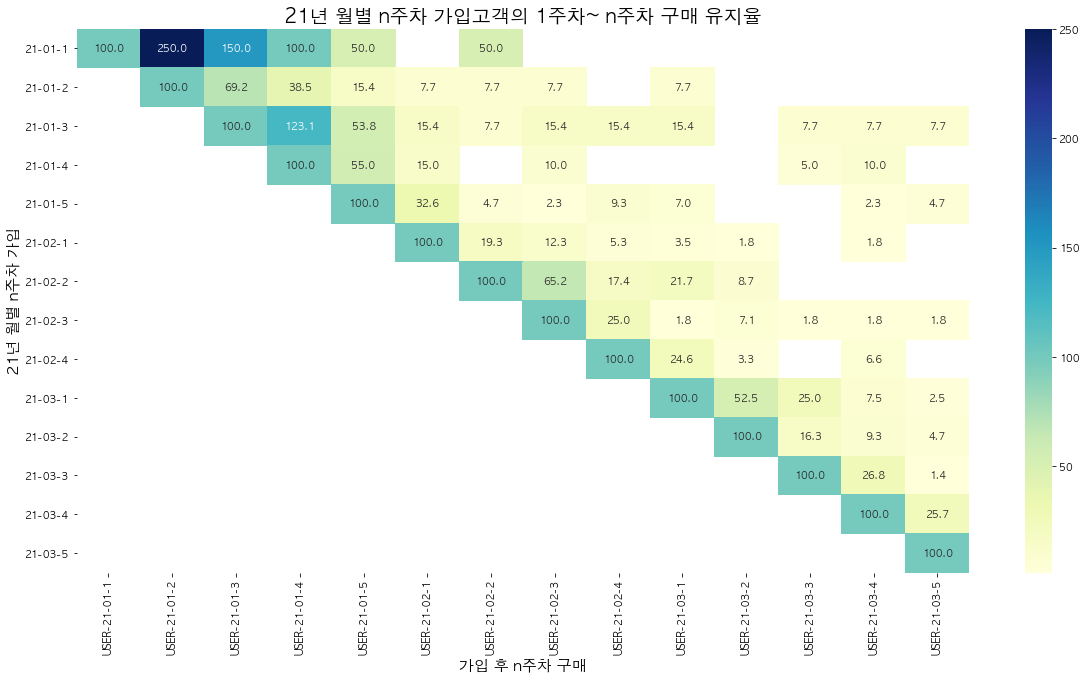

In [30]:
plt.figure(figsize=(20, 10))
plt.title('21년 월별 n주차 가입고객의 1주차~ n주차 구매 유지율', fontsize=19)
sns.heatmap(cohort_new_pivot, annot=True, fmt = '.1f', cmap='YlGnBu')
plt.ylabel('21년 월별 n주차 가입', fontsize=15)
plt.xlabel('가입 후 n주차 구매', fontsize=15)
plt.show();

# 21년 1월 1주차에 가입한 고객이 구매한 건수는 21년 1월 1주차에 14.3%, 2주차에 35.7%, 3주차에 14.3%, 4주차에 7.1%, 6주차에 7.1% 발생 

## 기존 유저들의 주차별 코호트 분석

In [57]:
## 기존 고객 
cohort_group = ndf.groupby(['reg_Month', 'order_date_ymw'])
cohort_df = cohort_group['USER'].apply(get_unique_no).reset_index()
cohort_old = cohort_df[cohort_df['reg_Month']<'21-01']
cohort_old_pivot = cohort_old.pivot(index='reg_Month', columns = 'order_date_ymw')


# ------------------------- 수정 ---------------------- # 
# 삭제
# div_num=cohort_old.groupby('reg_Month')['USER'].sum()

# 대체 
div_num=[]
for i in range(cohort_old_pivot.shape[0]):
    for j in range(cohort_old_pivot.shape[1]):
        if pd.isna(cohort_old_pivot.iloc[i][j])==False:
            first=cohort_old_pivot.iloc[i][j]
            div_num.append(first)
            break
# --------------------------------------------------- #       

        
cohort_old_pivot = cohort_old_pivot.div(div_num, axis=0) * 100

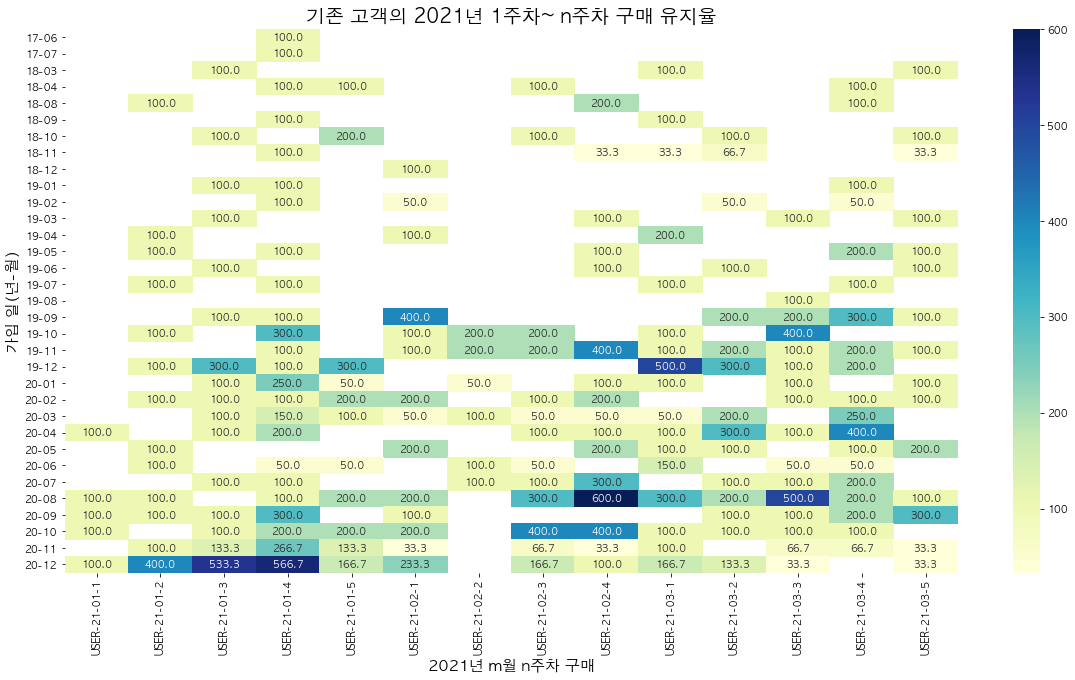

In [58]:
plt.figure(figsize=(20, 10))
plt.title('기존 고객의 2021년 1주차~ n주차 구매 유지율', fontsize=19)
sns.heatmap(cohort_old_pivot, annot=True,fmt = '.1f', cmap='YlGnBu')
plt.ylabel('가입 일(년-월)', fontsize=15)
plt.xlabel('2021년 m월 n주차 구매', fontsize=15)
plt.show();